# Real Time Image Captioning
In this file we have used opencv libraries to predict the caption of a real time video and display it on the screen.

## Importing Libraries

In [1]:
from keras.models import model_from_json, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import img_to_array, load_img
from keras.models import Model
from pickle import load, dump
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Importing Files saved in Previous Notebooks

In [2]:
with open("train_image_encodings.pkl", "rb") as f:
  train_image_encodings = load(f)

with open("train_captions.pkl", "rb") as f:
  train_captions = load(f)

with open("tokenizer.pkl", "rb") as f:
  tokenizer = load(f)

with open("model.json", "r") as f:
  model = model_from_json(f.read())

In [3]:
#Loading the saved weights
model.load_weights("model.h5")
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy')
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 39)           0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 39, 300)      706500      input_9[0][0]                    
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 2048)         0           input_8[0][0]                    
____________________________________________________________________________________________

In [4]:
#Declaring global variables
max_length = 39
dict_size = 2355
target_size = (299, 299, 3)
embedding_size = 300
epochs = 20
num_images_per_batch = 5
steps = len(train_captions)//num_images_per_batch

In [5]:
model.load_weights("model_epoch29.h5")

In [6]:
#Redefining the inceptionV3 model as done in pre-processing phase so that we can test the model on test set
incep = InceptionV3(weights = 'imagenet')
incep.layers.pop()
for layer in incep.layers:
  layer.trainable = False

inception = Model(inputs = incep.inputs, outputs = incep.layers[-1].output)
print(inception.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

## Defining Functions

In [7]:
#Redefining the function as declared in pre-processing phase, that encodes a PIL image into image encodings that can be fed into the model as input
def encode_img(id, model):
  img = load_img("{}".format(id), target_size = (299, 299))
  img_ar = img_to_array(img)
  img_dim = np.expand_dims(img_ar, axis = 0)
  img_ = preprocess_input(img_dim)
  predict = model.predict(img_)
  predict = predict.reshape(predict.shape[1])
  #print(predict.shape)
  return np.array(predict)

In [8]:
#Loading word_to_idx dictionary and idx_to_word dictionary which were pickled in pre-processing phase 
with open("word_to_idx", "rb") as f:
  word_to_idx = load(f)

with open("idx_to_word", "rb") as f:
  idx_to_word = load(f)

In [9]:
def beam_search(id, beam):
  encoded_img = np.expand_dims(encode_img(id, inception), axis = 0)
  start = [word_to_idx['startseq']]
  start_word = [[start,0.0]]
  while len(start_word[0][0]) < max_length:
    temp = []
    for s in start_word:
      #Padding the sequence of words to the length of max_length by adding 0's at the end
      sequence = np.expand_dims(pad_sequences([s[0]], maxlen = max_length, padding = "post")[0], axis = 0)
      #Predicting the captionword by word
      y_hat = model.predict([encoded_img, sequence], verbose = 0)
      sorting_word_pred = np.argsort(y_hat[0])[-beam:]
      for w in sorting_word_pred:
        caption, prob = s[0][:], s[1]
        caption.append(w)
        prob += np.log(y_hat[0][w])
        temp.append([caption, prob])

    start_word = temp
    start_word = sorted(start_word, key = lambda l : l[1])
    start_word = start_word[-beam:]
  start_word = start_word[-1][0]
  cap = [idx_to_word[i] for i in start_word]
  caption = []
  for i in cap:
    if i=='endseq':
      break 
    caption.append(i)
  caption = ' '.join(caption[1:])
  return caption

## Testing
We will again test our model on the first 10 test images, so that we can verify all files have been loaded properly or not.

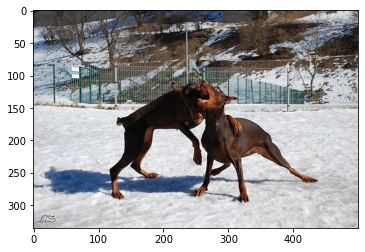

Caption:  a brown dog and a brown dog are playing in the snow


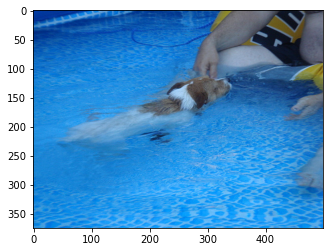

Caption:  a girl in a pink bathing suit jumps into a swimming pool


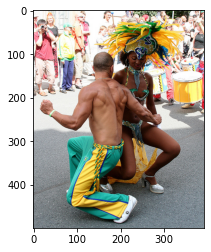

Caption:  a man in a black shirt is standing in front of a crowd of people


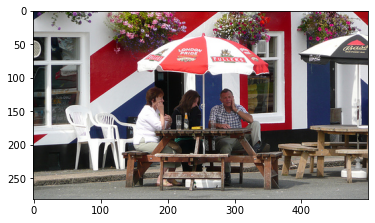

Caption:  a group of people sit on a bench in front of a restaurant


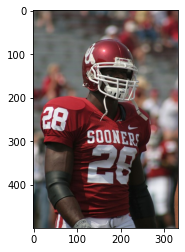

Caption:  a football player is being tackled by a player in red


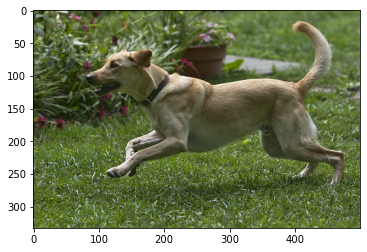

Caption:  a brown dog is running through the grass


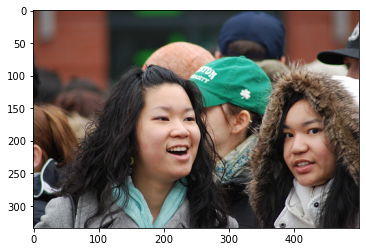

Caption:  a group of people are posing for a picture


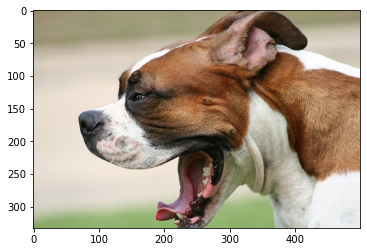

Caption:  a brown and white dog is running through the grass


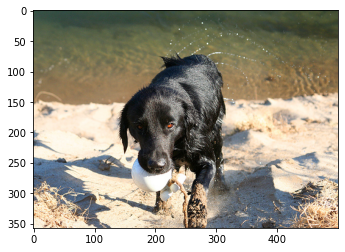

Caption:  a black and white dog is running through the water


In [10]:
with open("Flickr_8k.testImages.txt", "r") as f:
  test_images = f.read()

from PIL import Image
#We will test the first 10 images in the test set 
i = 0
for line in test_images.split("\n"):
  i += 1
  id = line.split('.')[0]
  img = plt.imread("Flickr8k_Dataset/Flicker8k_Dataset/{}.jpg" .format(id))
  plt.imshow(img)
  plt.show()
  pred = beam_search("Flickr8k_Dataset/Flicker8k_Dataset/{}.jpg" .format(id), 5)
  print("Caption: ", pred[:])
  if(i==9):
    break

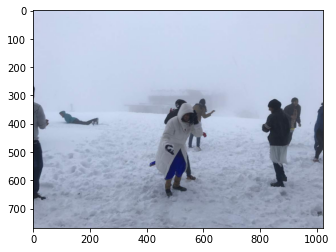

Caption:  a group of people are standing in the snow


In [11]:
#Beam Search
img = plt.imread("IMG-20170517-WA0038.jpg")
plt.imshow(img)
plt.show()
pred = beam_search("IMG-20170517-WA0038.jpg", 10)
print("Caption: ", pred[:])

## Using above Model to Caption a Live Video 

In [ ]:
import cv2
import textwrap

video_object = cv2.VideoCapture()
while(True):
    ret, frame = video_object.read()
    counter = 1
    target = 6
    while ret == True:
        if counter == target:
            ret, frame = video_object.read()
            cv2.imwrite("Video_stream/new.jpg", frame)
            pred = beam_search("Video_stream/new.jpg", 1)
            font = cv2.FONT_HERSHEY_TRIPLEX
            pred = textwrap.wrap(pred, 60)
            for i, line in enumerate(pred):
                textsize = cv2.getTextSize(line, font, 1, 2)[0]
                gap = textsize[1] + 10
                x = int((frame.shape[1] - textsize[0])/2)
                y = int((frame.shape[0] - textsize[1])/2) +250 + i*gap
                cv2.putText(frame, line, (x, y), font, 1, (255, 255, 255), 2, cv2.LINE_4)
                cv2.imshow('Capturing Video', frame)
            counter = 0
        else:
            ret = video_object.grab()
            counter += 1
        if cv2.waitKey(1) & 0xff == ord('q'):
            video_object.release()
            cv2.destroyAllWindows()
    else:
        break

## Using Above Model to Caption an Existing Video

In [14]:
import cv2
import textwrap

video_object = cv2.VideoCapture('2017 Korea Tourism TVC - Teaser.mp4')
if video_object.isOpened() == False:
    print("Couldn't open the video file.")
while(video_object.isOpened()):
    ret, frame = video_object.read()
    counter = 1
    target = 6
    while ret == True:
        if counter == target:
            ret, frame = video_object.read()
            cv2.imwrite("Video_stream/new.jpg", frame)
            pred = beam_search("Video_stream/new.jpg", 1)
            font = cv2.FONT_HERSHEY_TRIPLEX
            pred = textwrap.wrap(pred, 60)
            for i, line in enumerate(pred):
                textsize = cv2.getTextSize(line, font, 1, 2)[0]
                gap = textsize[1] + 10
                x = int((frame.shape[1] - textsize[0])/2)
                y = int((frame.shape[0] - textsize[1])/2) +250 + i*gap
                cv2.putText(frame, line, (x, y), font, 1, (255, 255, 255), 2, cv2.LINE_4)
                cv2.imshow('Capturing Video', frame)
            counter = 0
        else:
            ret = video_object.grab()
            counter += 1
        if cv2.waitKey(1) & 0xff == ord('q'):
            video_object.release()
            cv2.destroyAllWindows()
    else:
        break

#This output gets generated when you close the video file by pressing 'q' key.

UnidentifiedImageError: cannot identify image file 'Video_stream/new.jpg'